# K-anonymity

In [1]:
import pandas as pd

#### Enter dataset & privacy parameters

In [2]:
# all column names
columnNames = (
    'YearlyIncome',
    'Gender',
    'Age',
    'Illness',
)

# enter columns that are categorical fields here. Other columns should be numerical
categorical = set((
    'Gender',
    'Illness',
))


df = pd.read_csv("./mydataset.csv", sep=",", header=None, names=columnNames, index_col=False, engine='python')


feature_columns = ['YearlyIncome', 'Gender', 'Age'] # quasi identifiers
sensitive_column = 'Illness' # sensitiv attribute (4 unique values in myDataset.csv)

kAnonym = 4
lDivers = 4

# only for t-closeness: the sensitive attribute have to be a categorical value!
tClose = 0.2 # max. allowed Kolmogorov-Smirnov distance

In [3]:
df.head()

,YearlyIncome,Gender,Age,Illness
0,42000,Male,28,Asthma
1,30000,Female,23,Asthma
2,40000,Male,26,Asthma
3,25000,Female,62,Diabetes
4,32000,Male,58,Diabetes


In [4]:
for name in categorical:
    df[name] = df[name].astype('category')

#### Get value ranges of columns

- categorial: count(uniqueValues), 
- numbers: max - min,

In [5]:
def get_spans(df, partition, scale=None):
    """
    :param        df: the dataframe for which to calculate the spans
    :param partition: the partition for which to calculate the spans
    :param     scale: if given, the spans of each column will be divided
                      by the value in `scale` for that column
    :        returns: The spans of all columns in the partition
    """
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [6]:
full_spans = get_spans(df, df.index)
full_spans

{'YearlyIncome': 38708, 'Gender': 2, 'Age': 55, 'Illness': 4}

#### Split partition function
- takes a dataframe, partition and column
- returns 2 partitions
- splits at median (count(uniqueValues) or numerical)

In [7]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

#### Partitioning algorithm
-  splits the dataframe into smaller partitions based on the spread of values in the specified feature columns
-  ensures that each resulting partition is valid according to the is_valid function (later: check k-anonmity, l-diversity, t-closeness)


In [8]:
def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


#### k-anonymity check
- **Idea:** put k-anonymity check into partition_dataset(..., is_valid)

In [9]:
def is_k_anonymous(df, partition, sensitive_column, k=kAnonym):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

#### Calculate partitions for k-anonymity
- At first only two columns from the dataset are selected that we apply the partitioning to. 
- This makes it easier to check/visualize the result and speed up the execution.

In [10]:
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [11]:
# number of partitions that were created
len(finished_partitions)

8

#### Visualize the created partitions

- functions to get the rectangular bounds of a partition along 2 columns
- plot these rects to see how our partitioning function divides the dataset
- ##### Goal: resulting rects should not overlap and cover the entire dataset.


* Overlapping rectangles could mean that some records are covered by multiple rectangles, potentially increasing the risk of re-identification.

In [12]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [13]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [14]:
# calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [15]:
# rects
rects[:10]

[((23190.0, 0.0), (39460.0, 1.0)),
 ((25000.0, 0.0), (40000.0, 1.0)),
 ((22676.0, 1.0), (40881.0, 2.0)),
 ((21268.0, 1.0), (32684.0, 2.0)),
 ((42000.0, 1.0), (58206.0, 2.0)),
 ((40997.0, 1.0), (59976.0, 2.0)),
 ((43980.0, 0.0), (58937.0, 1.0)),
 ((40881.0, 0.0), (59976.0, 1.0))]

In [16]:
# plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

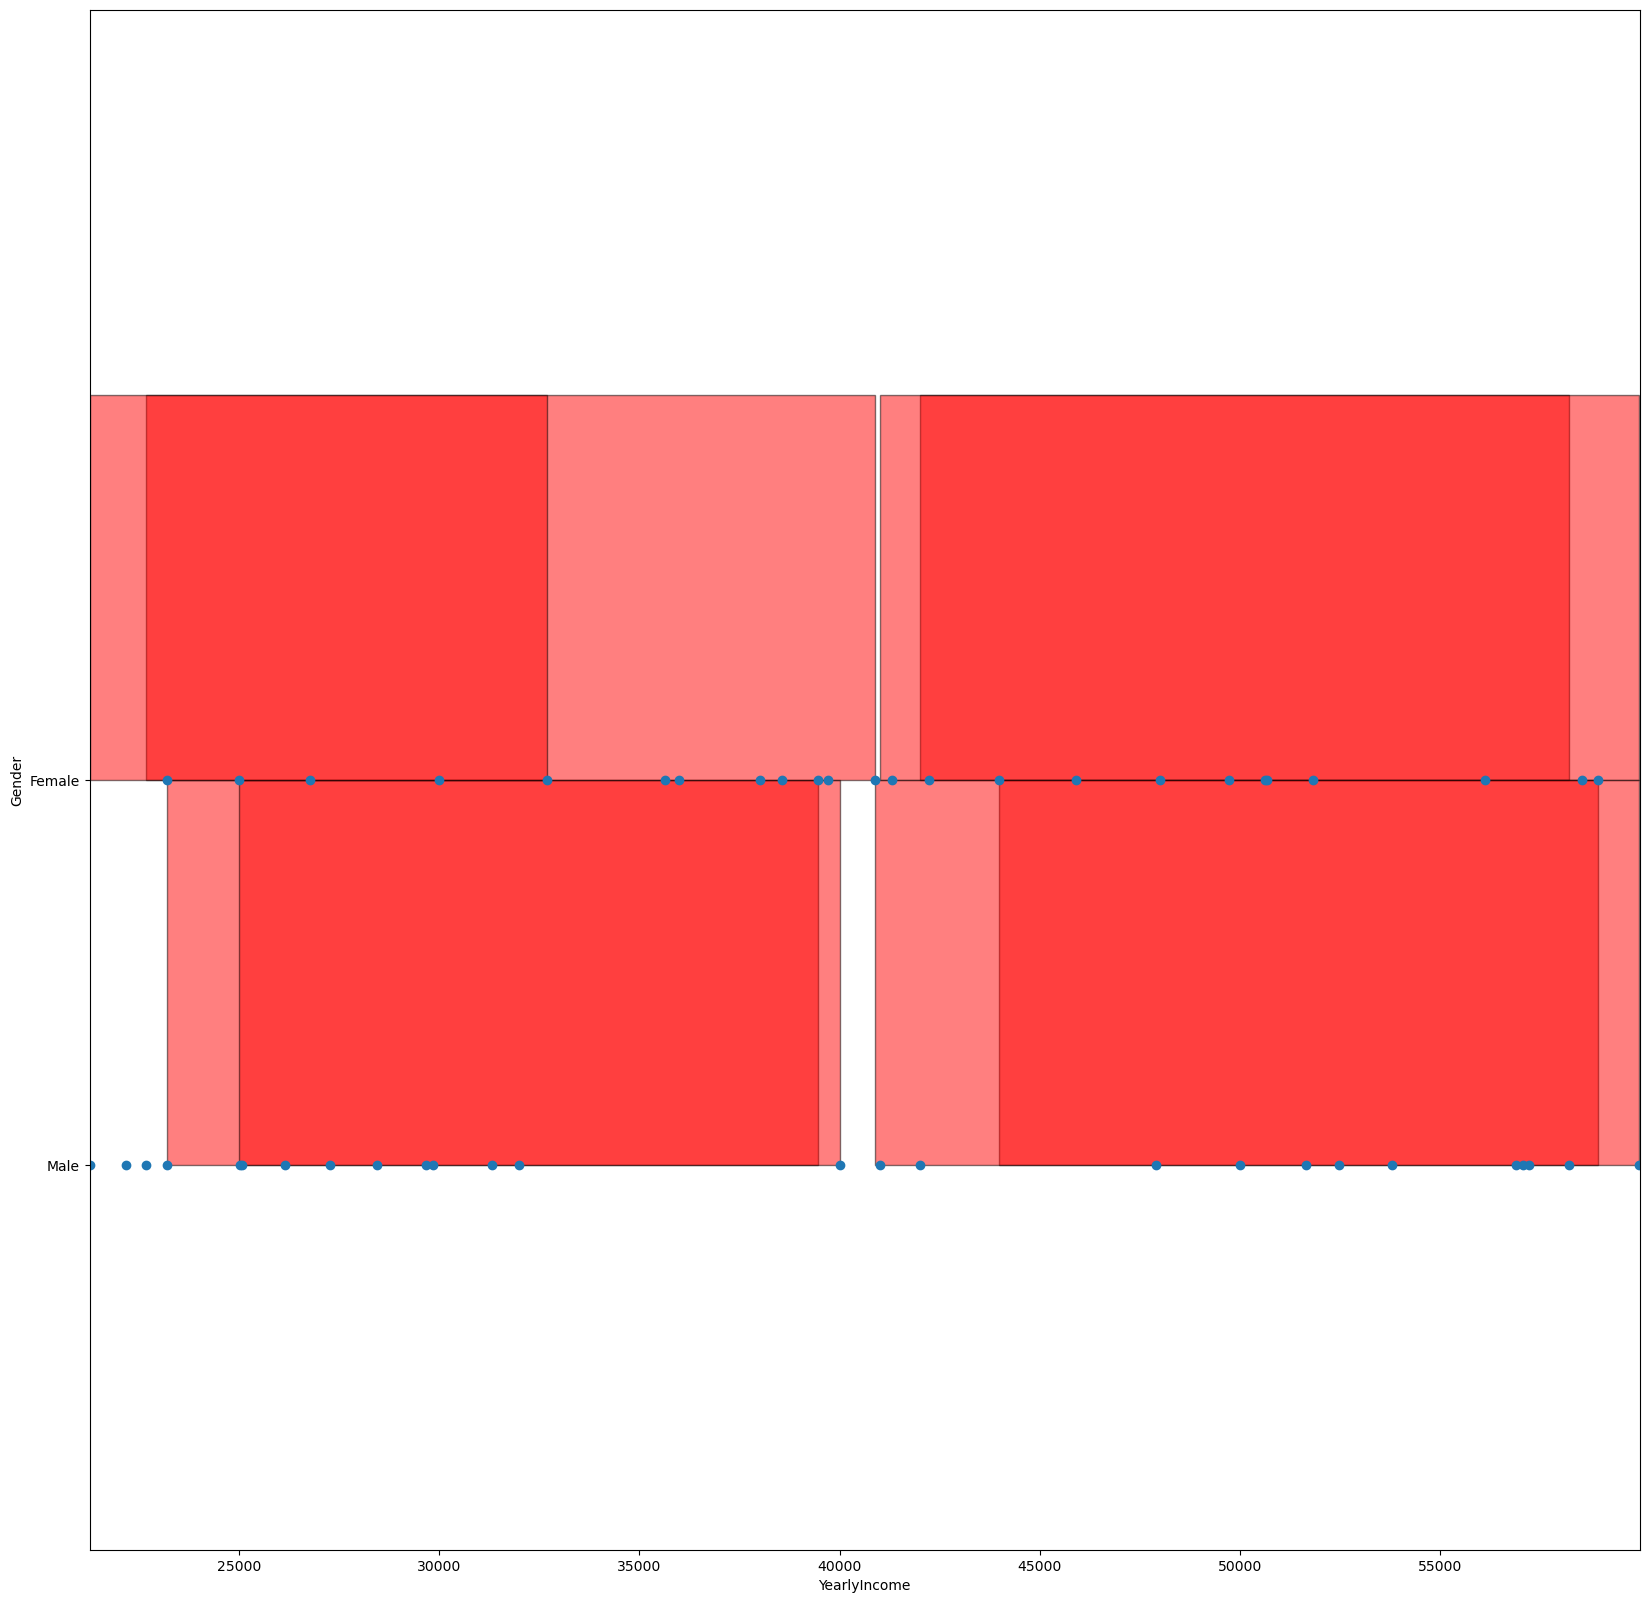

In [17]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

# Generating k-Anonymous Dataset

- produce new dataset which contains one row for each partition and value of the sensitive attribute 

- -> aggregate the columns in each partition

In [38]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

def agg_numerical_columnAsRang(series):
    return [series.min(), series.max()]

In [19]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        
        grouped_columns = df.loc[partition].agg(aggregations)
        
        # Ensure grouped_columns is a DataFrame for consistent access
        if isinstance(grouped_columns, pd.Series):
            grouped_columns = grouped_columns.to_frame().T
        
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column: 'count'})
        
        values = grouped_columns.iloc[0].to_dict()  # Assuming single-row DataFrame
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column: sensitive_value,
                'count': count,
            })
            rows.append(values.copy())
    
    return pd.DataFrame(rows)


In [39]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

hellu 30000
hellu 1     30000
6     38000
7     36000
11    23190
32    38569
Name: YearlyIncome, dtype: int64
hellu 23
hellu 1     23
6     32
7     33
11    36
32    44
Name: Age, dtype: int64
Finished 1 partitions...
hellu 25000
hellu 3     25000
10    39711
13    26771
24    39460
36    32684
40    35633
Name: YearlyIncome, dtype: int64
hellu 62
hellu 3     62
10    54
13    78
24    77
36    46
40    77
Name: Age, dtype: int64
hellu 40000
hellu 2     40000
15    29842
18    27271
20    22676
35    23201
47    29680
49    26145
Name: YearlyIncome, dtype: int64
hellu 26
hellu 2     26
15    43
18    44
20    27
35    43
47    34
49    32
Name: Age, dtype: int64
hellu 32000
hellu 4     32000
12    21268
19    25021
25    25078
28    22180
34    28440
37    31317
Name: YearlyIncome, dtype: int64
hellu 58
hellu 4     58
12    63
19    54
25    50
28    68
34    45
37    70
Name: Age, dtype: int64
hellu 42000
hellu 0     42000
5     50000
14    53805
29    57210
31    57055
46    56891


In [21]:
# sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,YearlyIncome,Gender,Age,Illness,count
10,26472.000000,Male,58.285714,Asthma,1
11,26472.000000,Male,58.285714,Cancer,1
12,26472.000000,Male,58.285714,Dementia,2
13,26472.000000,Male,58.285714,Diabetes,3
6,28402.142857,Male,35.571429,Asthma,3
7,28402.142857,Male,35.571429,Cancer,2
8,28402.142857,Male,35.571429,Dementia,1
9,28402.142857,Male,35.571429,Diabetes,1
0,33151.800000,Female,33.600000,Asthma,2
1,33151.800000,Female,33.600000,Cancer,2


# L-diversity (naive)

* Modify `is_valid` function to not only check for the size of a given partition but also ensure that the values of the sensitive attribute in the partition are diverse enough
* Modify the `split` function to produce splits that are diverse (if possible)

In [22]:
def diversity(df, partition, column):
    return len(df[column][partition].unique())

def is_l_diverse(df, partition, sensitive_column, l=lDivers):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param                l: The minimum required diversity of sensitive attribute values in the partition
    """
    return diversity(df, partition, sensitive_column) >= l

In [23]:
# partition dataset with is_valid function: is_k_anonymous & is_l_diverse
finished_l_diverse_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_l_diverse(*args))

In [24]:
# length of partitions (=k)
len(finished_l_diverse_partitions)

5

In [25]:
column_x, column_y = feature_columns[:2]
l_diverse_rects = get_partition_rects(df, finished_l_diverse_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

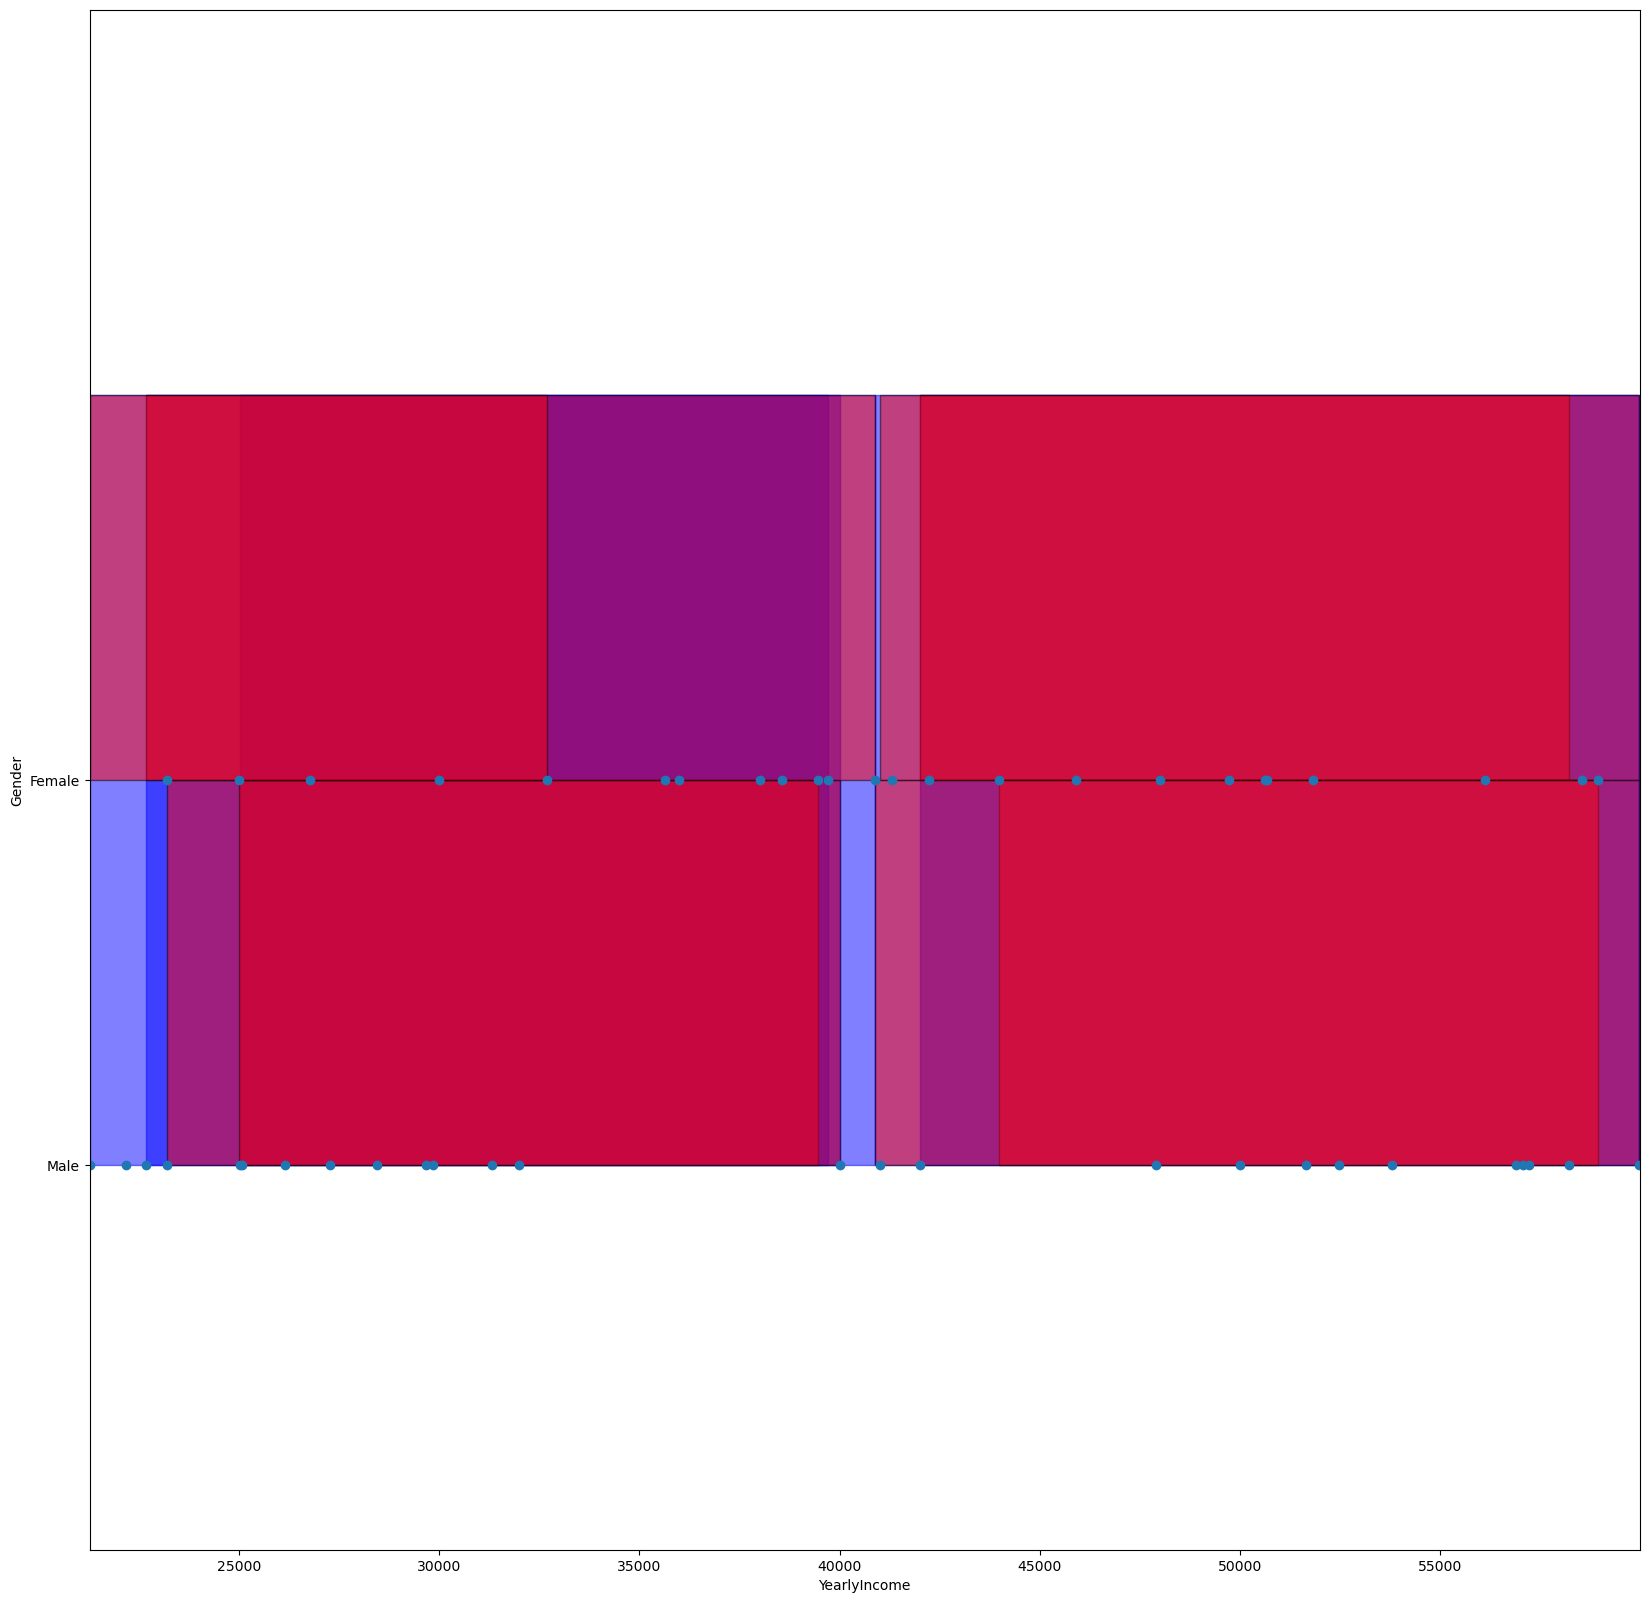

In [26]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, l_diverse_rects, column_x, column_y, edgecolor='b', facecolor='b')
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [27]:
# build an anonymized dataset from the l-diverse partitions
dfl = build_anonymized_dataset(df, finished_l_diverse_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [28]:
dfl.sort_values([column_x, column_y, sensitive_column])

,YearlyIncome,Gender,Age,Illness,count
16,28804.142857,"Male,Female",70.714286,Asthma,1
17,28804.142857,"Male,Female",70.714286,Cancer,2
18,28804.142857,"Male,Female",70.714286,Dementia,1
19,28804.142857,"Male,Female",70.714286,Diabetes,3
0,30381.166667,"Male,Female",34.750000,Asthma,5
1,30381.166667,"Male,Female",34.750000,Cancer,4
2,30381.166667,"Male,Female",34.750000,Dementia,1
3,30381.166667,"Male,Female",34.750000,Diabetes,2
12,30489.000000,"Male,Female",51.166667,Asthma,2
13,30489.000000,"Male,Female",51.166667,Cancer,1


# T-closeness

- **sensitive attribute is a have to be a categorical value!!**
- add to is_valid function: t_closeness condition
- calcultated: Kolmogorov-Smirnov distance between the empirical probability distribution of the sensitive attribute over the entire dataset vs. the distribution over
the partition

In [29]:
# generate the global frequencies for the sensitive column 
global_freqs = {}
total_count = float(len(df))
group_counts = df.groupby(sensitive_column)[sensitive_column].agg('count')
for value, count in group_counts.to_dict().items():
    p = count/total_count
    global_freqs[value] = p

In [30]:
# distribution of sensitve attributes
global_freqs

{'Asthma': 0.36, 'Cancer': 0.18, 'Dementia': 0.2, 'Diabetes': 0.26}

In [31]:
def t_closeness(df, partition, column, global_freqs):
    total_count = float(len(partition))
    d_max = None
    group_counts = df.loc[partition].groupby(column)[column].agg('count')
    for value, count in group_counts.to_dict().items():
        p = count/total_count
        d = abs(p-global_freqs[value])
        if d_max is None or d > d_max:
            d_max = d
    return d_max


def is_t_close(df, partition, sensitive_column, global_freqs, p=tClose):
    """
    :param               df: The dataframe for which to check l-diversity
    :param        partition: The partition of the dataframe on which to check l-diversity
    :param sensitive_column: The name of the sensitive column
    :param     global_freqs: The global frequencies of the sensitive attribute values
    :param                p: The maximum allowed Kolmogorov-Smirnov distance
    """
    if not sensitive_column in categorical:
        raise ValueError("this method only works for categorical values")
    return t_closeness(df, partition, sensitive_column, global_freqs) <= p

In [32]:
finished_t_close_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, lambda *args: is_k_anonymous(*args) and is_t_close(*args, global_freqs))

In [33]:
# length partitions (=k)
len(finished_t_close_partitions)

5

In [34]:
dft = build_anonymized_dataset(df, finished_t_close_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


### Result table (k-anonym, l-divers & t-close)

In [35]:
dft.sort_values([column_x, column_y, sensitive_column])

,YearlyIncome,Gender,Age,Illness,count
10,23652.714286,Male,48.142857,Asthma,2
11,23652.714286,Male,48.142857,Cancer,1
12,23652.714286,Male,48.142857,Dementia,2
13,23652.714286,Male,48.142857,Diabetes,2
14,31221.428571,Male,45.714286,Asthma,2
15,31221.428571,Male,45.714286,Cancer,2
16,31221.428571,Male,45.714286,Dementia,1
17,31221.428571,Male,45.714286,Diabetes,2
0,33183.454545,Female,51.090909,Asthma,4
1,33183.454545,Female,51.090909,Cancer,4


### Result visualized

- rects/partitions do not overlap and cover the entire dataset

In [36]:
column_x, column_y = feature_columns[:2]
t_close_rects = get_partition_rects(df, finished_t_close_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

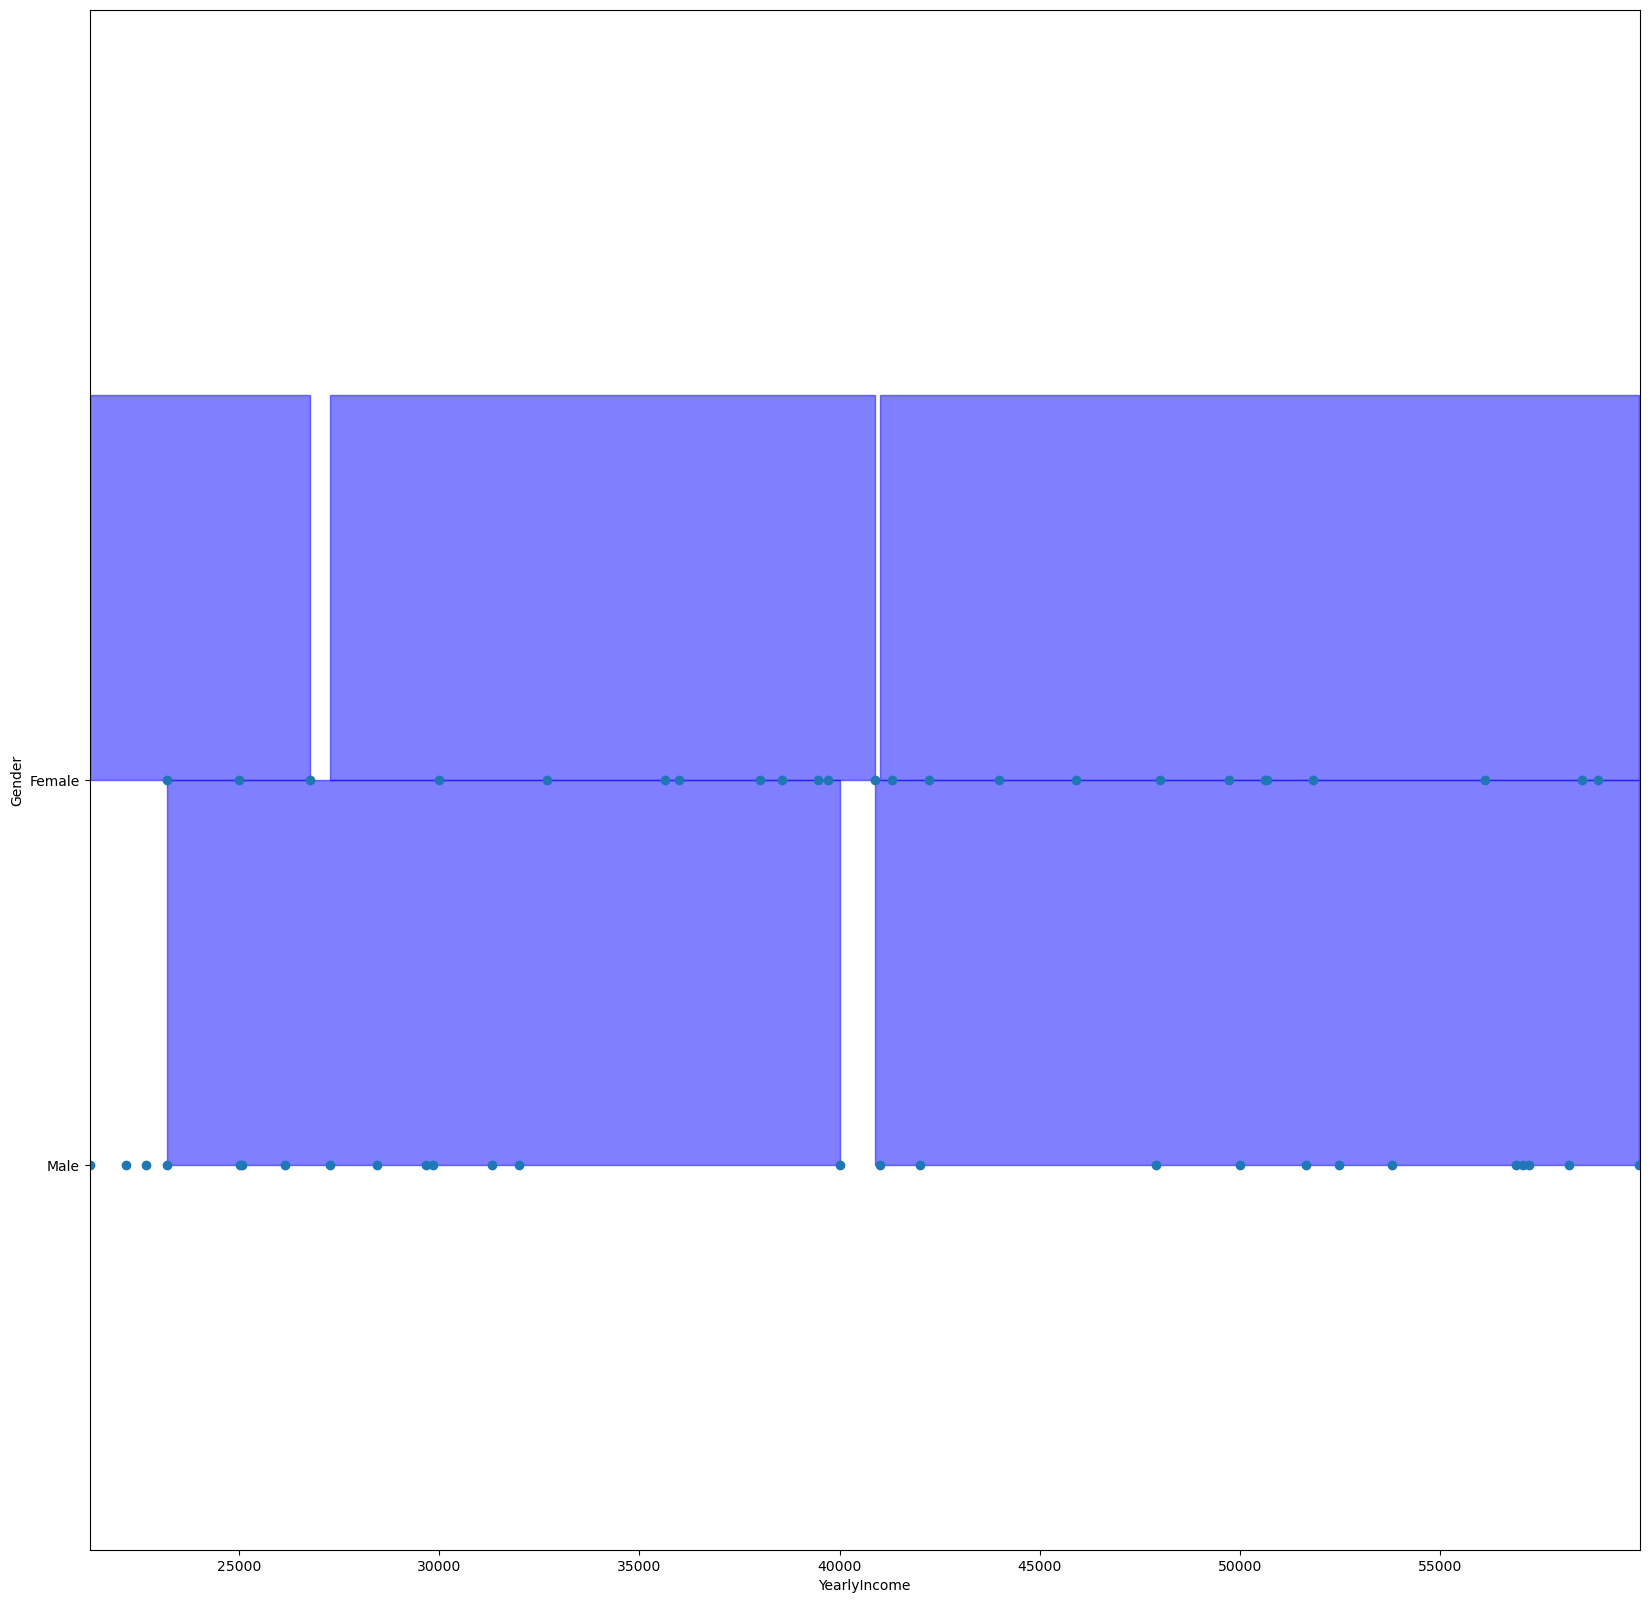

In [37]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, t_close_rects, column_x, column_y, edgecolor='b', facecolor='b')
pl.scatter(df[column_x], df[column_y])
pl.show()